Для воспроизводимости кода установим определенную версию tensorflow и keras

In [1]:
!pip install -q tensorflow==2.1

     |████████████████████████████████| 421.8 MB 23 kB/s 
     |████████████████████████████████| 448 kB 46.5 MB/s 
     |████████████████████████████████| 3.8 MB 32.4 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.


In [2]:
!pip install keras==2.3.1

     |████████████████████████████████| 377 kB 5.3 MB/s 
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [4]:
print("We're using TF", tf.__version__)
print("We are using Keras", keras.__version__)

We're using TF 2.1.0
We are using Keras 2.2.4-tf


In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-84d44810-97ca-8715-1e71-7069ebe00808)


In [7]:
#use this command to see GPU activity while doing Deep Learning tasks, for this command 'nvidia-smi' and for above one to work, go to 'Runtime > change runtime type > Hardware Accelerator > GPU'
!nvidia-smi

Mon Jan 31 15:22:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    63W / 149W |     60MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# MNIST

In [8]:
# скачиваем данные
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [9]:
# что за данные
print(x_train.shape)
print(x_val.shape)
print (y_train[:10])
print (y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


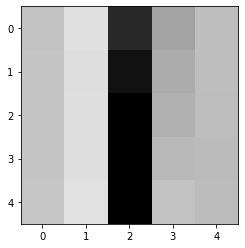

Пример картинки:


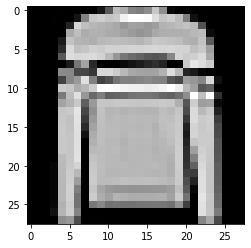

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [10]:
# нарисуем картинку
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train.shape)), y_train[:10])

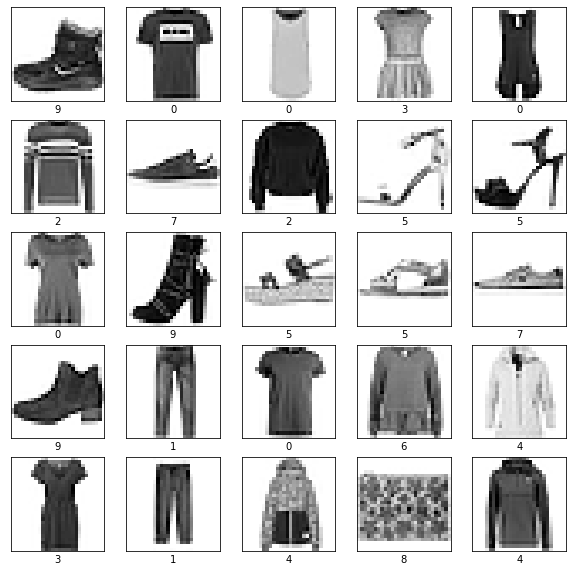

In [11]:
# Посмотрим побольше примеров
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap="Greys")
    plt.xlabel(y_train[i])
plt.show()

# Data

In [12]:
# вытянем картинку в вектор размера 28*28=784 и будем использовать это как фичи!

x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [13]:
# центрируем и нормируем, так сети будет проще учиться
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

# по сути, это действия аналогичны нормализации через StandardScaler
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x_train_flat = scaler.fit_transform(x_train_flat)
# x_val_flat = scaler.transform(x_val_flat)

# Но попробуйте пропустить нормирование и посмотрите что будет ;)
# x_train_float = x_train_flat.astype(np.float)
# x_val_float = x_val_flat.astype(np.float)

In [14]:
# one-hot encode для ответов
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


# Собираем модель

Самостоятельно постойте Multi layer Perceptron (MLP) классификатор (по аналогии с практическеской частью, но на новых данных)

In [ ]:
clear_session()

In [15]:
x_train_float.shape[1]

784

In [16]:
# Тут ваш код Архитектуры сети
# не забудьте 10 выходов с активацией softmax на выходном слое!

# Архитектура сети
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [19]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 6s 95us/sample - loss: 0.4905 - accuracy: 0.8237 - val_loss: 0.4167 - val_accuracy: 0.8493
Epoch 2/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.3682 - accuracy: 0.8637 - val_loss: 0.3911 - val_accuracy: 0.8588
Epoch 3/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.3310 - accuracy: 0.8773 - val_loss: 0.4050 - val_accuracy: 0.8547
Epoch 4/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.3053 - accuracy: 0.8866 - val_loss: 0.3474 - val_accuracy: 0.8712
Epoch 5/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2879 - accuracy: 0.8925 - val_loss: 0.3476 - val_accuracy: 0.8736
Epoch 6/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2729 - accuracy: 0.8987 - val_loss: 0.3489 - val_accuracy: 0.8724
Epoch 7/10
60000/60000 [==============================] 

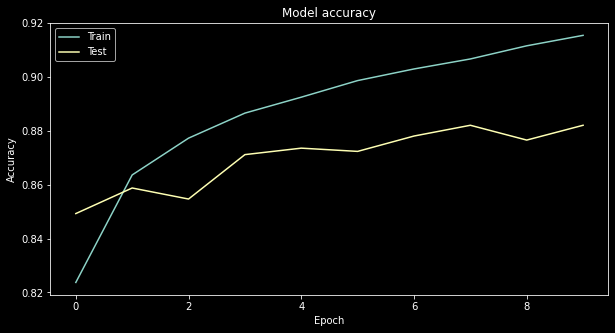

In [20]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

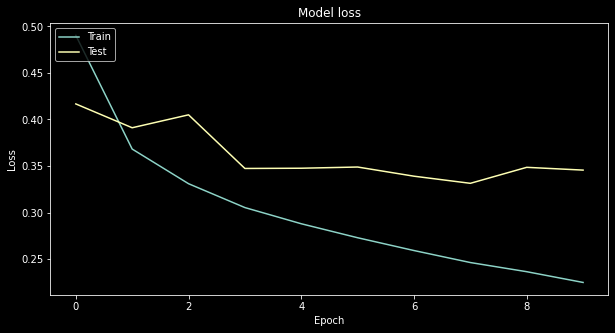

In [21]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [22]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.8821


Что вам необходимо сделать:
1. Обучите сеть без скрытых слоев. (Построить аналог обычной линейной модели) **Какое accuracy на валидации получили?**
2. Обучите сеть с двумя скрытыми слоями по 128 нейронов в каждом. **Какое accuracy на валидации получили?**
3. **Сколько параметров в последней сети?**

Удачи!

In [28]:
#from keras.layers import Input

Using TensorFlow backend.


In [34]:
clear_session()

In [35]:
model = Sequential()
#model.add(Dense(128, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
#model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax', input_shape=(x_train_float.shape[1],))) # выходной слой

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [38]:
history = model.fit(
                    x_train_float, 
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=10,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 78us/sample - loss: 0.6184 - accuracy: 0.7914 - val_loss: 0.5179 - val_accuracy: 0.8169
Epoch 2/10
60000/60000 [==============================] - 4s 64us/sample - loss: 0.4720 - accuracy: 0.8361 - val_loss: 0.4823 - val_accuracy: 0.8317
Epoch 3/10
60000/60000 [==============================] - 4s 63us/sample - loss: 0.4465 - accuracy: 0.8443 - val_loss: 0.4749 - val_accuracy: 0.8335
Epoch 4/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.4329 - accuracy: 0.8503 - val_loss: 0.4598 - val_accuracy: 0.8388
Epoch 5/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.4233 - accuracy: 0.8526 - val_loss: 0.4574 - val_accuracy: 0.8370
Epoch 6/10
60000/60000 [==============================] - 4s 65us/sample - loss: 0.4184 - accuracy: 0.8542 - val_loss: 0.4588 - val_accuracy: 0.8357
Epoch 7/10
60000/60000 [==============================] 

In [39]:
predicts = model.predict_classes(x_val_float)
print('Test Accuracy: ', accuracy_score(y_val, predicts))

Test Accuracy:  0.8398
